### This first part is the analysis, part 2 is the backtester

In [0]:
#standard imports

import requests
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline




In [0]:
#nice trick to make plots full width

plt.rcParams['figure.figsize'] = [15,5]

In [0]:
#fetch daily OHLC prices for 

btc = requests.get("https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=500").json()['Data']
bch = requests.get("https://min-api.cryptocompare.com/data/histoday?fsym=BCH&tsym=USD&limit=500").json()['Data']

In [0]:
#put into dataframe

btc_df = pd.DataFrame(btc)
bch_df = pd.DataFrame(bch)

#use pandas datetime feature to convert timestamp into a datatime object with units = seconds

btc_df['time'] = pd.to_datetime(btc_df['time'], unit='s')
bch_df['time'] = pd.to_datetime(bch_df['time'], unit='s')

#use the newly created datetime object as index

btc_df.set_index('time', inplace=True)
bch_df.set_index('time', inplace=True)

#rename 'close' for each instrument so they have unique names

btc_df.rename({'close':'btc'}, axis=1, inplace=True)
bch_df.rename({'close':'bch'}, axis=1, inplace=True)
btc_df = btc_df.loc['2017-12-12':]
bch_df = bch_df.loc['2017-12-12':]


In [5]:
btc_df.head()

,btc,high,low,open,volumefrom,volumeto
time,,,,,,
2018-05-29,7474.75,7533.03,7069.01,7118.88,86536.70,6.348493e+08
2018-05-30,7393.02,7571.08,7295.78,7474.75,67797.62,5.058710e+08
2018-05-31,7502.15,7608.87,7349.52,7393.02,60780.47,4.582240e+08
2018-06-01,7530.55,7614.66,7370.27,7501.74,61082.25,4.586877e+08
2018-06-02,7643.26,7697.34,7467.79,7530.55,47435.99,3.624149e+08


In [0]:
#we'll work with just the closing pries for this project, so concatenate the 2 columns together.

df = pd.concat([btc_df['btc'], bch_df['bch']],axis=1)

#we'll also add the raw spread as a column

#calculate the spread between the 2 prices, this is what we'll be analysing.

df['spread'] = df['btc'] - df['bch']


In [0]:
df.head()

,btc,bch,spread
time,,,
2017-12-12,17083.90,1543.45,15540.45
2017-12-13,16286.82,1572.91,14713.91
2017-12-14,16467.91,1933.27,14534.64
2017-12-15,17604.85,1795.31,15809.54
2017-12-16,19345.49,1773.75,17571.74


In [0]:
#test for cointegration

from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm


In [0]:
#select a training sample
btc_train, bch_train = df['btc'].loc['2017-12-12':'2018-4-30'], df['bch'].loc['2017-12-12':'2018-4-30']
spread_train = btc_train - bch_train

In [9]:
#return p value
t,p,crit = coint(btc_train,bch_train)

ValueError: ignored

In [10]:
#test for significance
print(p)
if p <0.05:
    print('Cointegrated!')
else:
    print('NOT Cointegrated')

NameError: ignored

In [11]:
#use adf to test for stationarity

pval_spread = adfuller(spread_train)[1]
if pval_spread <0.05:
    print(pval_spread,'Data is Stationary!')
else:
    print(pval_spread, 'Data is NOT Stationary!')
#note the spread itself is Not stationary as it assumes a 'Beta' value of 1
#so we need to construct a linear model to find the optimal Beta value...


ValueError: ignored

In [0]:
#build linear model to find beta that gives I(0) combination of pair

X = sm.add_constant(bch_train)
result = sm.OLS(btc_train,X).fit()

print(result.params)
#define new stationary spread as 'z'
b = result.params['bch']
z = btc_train - b*bch_train



const    4799.480968
bch         3.995977
dtype: float64


0.000904184195413192 Huzzah!, it's Stationary


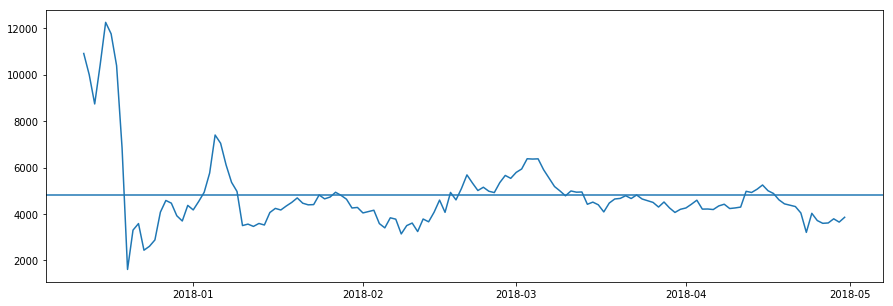

In [0]:
#run adf again, this time on linear combination 'Z'

plt.plot(z)
z_pval = adfuller(z)[1]
if z_pval<0.01:
    print(z_pval,"Huzzah!, it's Stationary")
else:
    print(z_pval,":Not stationary")
plt.axhline(z.mean())

In [0]:
df.head()

,btc,bch,spread
time,,,
2017-12-12,17083.90,1543.45,15540.45
2017-12-13,16286.82,1572.91,14713.91
2017-12-14,16467.91,1933.27,14534.64
2017-12-15,17604.85,1795.31,15809.54
2017-12-16,19345.49,1773.75,17571.74


In [0]:
#calculate cointegrated series 'full_z' for the whole (train + test) dataset

spread = df['spread']

full_z = df['btc'] - b*df['bch']

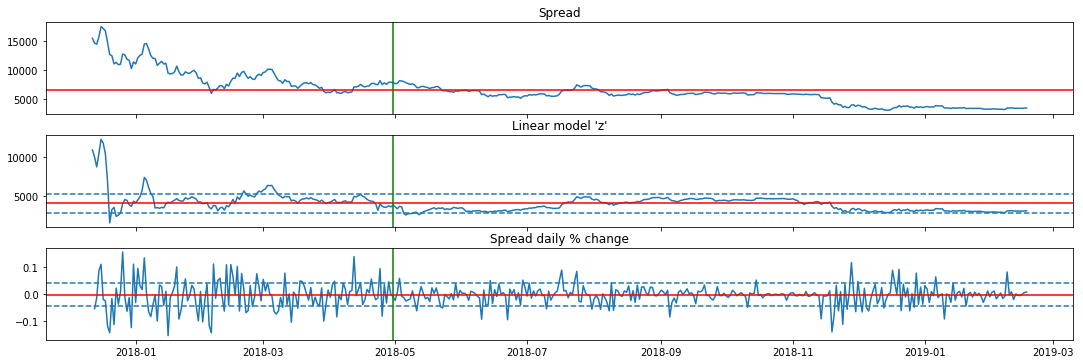

In [0]:
#lets plot the raw spread, the stationary spread and for reference the 'spread daily percent change' or 'returns'
#the green vertical line shows the end of the training set period.

fig,ax = plt.subplots(3,1,sharex=True)

plt.tight_layout()
ax[0].set_title('Spread')
ax[0].plot(spread)
ax[0].axhline(spread.mean(),color='r')

#stationary series 'z' plotted with 1 standard deviation horizontal bars shown
#note standard dev bars are arbitrary and for reference only

ax[1].set_title("Linear model 'z'")
#plot inverse so its same as 'Spread'
full_z_mu = full_z.mean()
ax[1].plot(full_z)
ax[1].axhline(full_z_mu+full_z.std(),ls ='--')
ax[1].axhline(full_z.mean(),color='r')
ax[1].axhline(full_z_mu-full_z.std(),ls ='--')

#spread pct change  / returns with 1 standard deviation horizontal bars shown
#note standard dev bars are arbitrary and for reference only
spread_pct = spread.pct_change(1)
#print(new_diff.head())
#print(new_df.head())
ax[2].set_title('Spread daily % change')
ax[2].plot(spread_pct)
ax[2].axhline(spread_pct.std(),ls='--')
ax[2].axhline(spread_pct.mean(),color='r')
ax[2].axhline(-spread_pct.std(),ls='--')

#mark end of training sample
for i in range(3):
    ax[i].axvline('2018-4-30',color='g')
#new_diff.rolling(20).mean().plot(style='r+')
#plt.axhline(color='r')
#plt.text(390,0,'ZERO')
#new_diff.rolling(10).mean().plot(style='--')

In [0]:
df['shift'] = df['spread'].diff()

In [0]:
df.head()

,btc,bch,spread,shift
time,,,,
2017-12-12,17083.90,1543.45,15540.45,NaN
2017-12-13,16286.82,1572.91,14713.91,-826.54
2017-12-14,16467.91,1933.27,14534.64,-179.27
2017-12-15,17604.85,1795.31,15809.54,1274.90
2017-12-16,19345.49,1773.75,17571.74,1762.20


In [0]:
df.tail()

,btc,bch,spread,shift
time,,,,
2019-02-13,3605.87,121.72,3484.15,-11.31
2019-02-14,3588.72,120.67,3468.05,-16.10
2019-02-15,3593.49,120.99,3472.50,4.45
2019-02-16,3617.24,121.40,3495.84,23.34
2019-02-17,3650.43,123.68,3526.75,30.91


C:\Users\Patrick\Anaconda3\envs\backTester\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[-2500. -2000. -1500. -1000.  -500.     0.   500.  1000.  1500.  2000.]


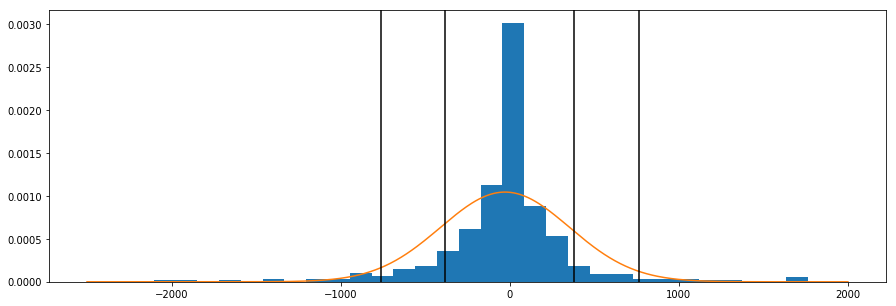

In [0]:
#hist of the shift ( diff of spread)
shift = df['shift'][1:]
plt.hist(shift,bins=30,normed=True)
xt = plt.xticks()[0]
print(xt)
x_min = min(xt)
x_max = max(xt)
rng = np.linspace(x_min,x_max,len(shift))
mu,sigma = stats.norm.fit(shift)

fitted = stats.norm.pdf(rng,mu,sigma)
plt.plot(rng,fitted,label='normal')
sstd = shift.std()
for i in [sstd, -sstd,sstd*2,-sstd*2]:
    plt.axvline(x=i, color='k')


    #plt.legend()

In [0]:
####################################


### part 2: Backtester

In [0]:
plt.rcParams['figure.figsize'] = [20,8]

In [0]:
#fetches crypto data, cleans then passes to container df3

#Class to store data for any pairs, crypto or otherwise
class Data_Puller:
    def __init__(self,ticker1,ticker2,freq,periods):
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.freq = freq
        self.periods = periods
        self.df3 = pd.DataFrame()
        
        
        
    #method to pull, munge, store crypto pairs data
    def get_data(self):
        #replace this in final merge
        b = 3.995977
        _data1 = requests.get(f"https://min-api.cryptocompare.com/data/histo{self.freq}?fsym={self.ticker1}&tsym=USD&limit={self.periods}").json()['Data']
        _data2 = requests.get(f"https://min-api.cryptocompare.com/data/histo{self.freq}?fsym={self.ticker2}&tsym=USD&limit={self.periods}").json()['Data']
        df1 = pd.DataFrame(_data1)
        df1_close = df1['close']
        df2 = pd.DataFrame(_data2)
        df2_close = df2['close']
        
        df1['time'] = pd.to_datetime(df1['time'],unit='s')
        df1.set_index(df1['time'], inplace = True)
        
        df2['time'] = pd.to_datetime(df2['time'],unit='s')
        df2.set_index(df2['time'], inplace = True)
        df1 = df1.drop(['high','low','open','volumefrom','volumeto','time'] ,axis=1)
        df2 = df2.drop(['high','low','open','volumefrom','volumeto'] ,axis=1)
        df1.rename(columns={'close': 'BTC'}, inplace=True)
        df2.rename(columns={'close': 'BCH'}, inplace=True)
        #print(df1.head())
        #print(df2.head())
        self.df3 = pd.concat([df1,df2],axis=1)
        #self.df3['spread'] = self.df3[self.ticker1] - self.df3[self.ticker2]
        #self.df3['spread_pct_change'] = self.df3['spread'].pct_change()
        #add cointegration model X1 - X2 = should be stationary
        self.df3['full_z_coint'] = self.df3['BTC'] - b*self.df3['BCH']
        self.df3['b_x_bch'] = b*self.df3['BCH']
        
        #prints df to check data
        print(self.df3)
        
    #returns the final dataframe, with 1st element dropped as its nan for spread_pct_change    
    def fetch_df(self):
        return self.df3.loc['2017-12-12':]
        

In [0]:
#x = Data_Puller('BTC','BCH','day',500)

In [0]:
#pd.set_option('display.max_rows', 400)
#x.get_data()

In [0]:
#instantiate DataPuller class then fetch_data
#q = x.fetch_df()

In [0]:
#view head of df ( note the dropped nan from 1st row )
#q[:5]

In [0]:
class Portfolio:
    def __init__(self):
        #self.orders = pd.DataFrame(columns=['TS','Order','tick1','tick2'])
        self._port = pd.DataFrame(columns=['ts','signal','action','sold_value','bought_value','U_pnl','R_pnl'])
#        self.current_budget = 1000000
        self.signal = None
        self.prev = None
        #bought / sold
        self.current_pos= "empty"
        #self.pnl = pd.DataFrame(columns = ['pnl'])
        self.bought_sold_price = 0
        self.stamp = 0
        #self.sold_value = 0
        #self.bot_value = 0
        self.sell_units = 0
        self.buy_units = 0
        self.value_2 = 0
        self.value_1 = 0
        self.rpl = 0
    
    def close_out(self):
        self.rpl += (1000 - self.value_2) + (self.value_1 - 1000)
        self.current_pos ='empty'

        print("close out position")
        
    """def close_out(c1,p1,c2,p2):
        print( "close out position")
        x = c1*p1 - old_c1_p1
        y = c2*p2 - old_c2_p2
        
        new_pnl = x+y """
        
        
        
        
    def position(self,ts,tick1,tick2,price,tot_trade_amount=2000):
        print()
        print(self.stamp)
        print('current pos:',self.current_pos)
        print("bought / sold price: ",self.bought_sold_price)
        print('this is prev:', self.prev)
        print('this is the signal:',self.signal)
        single_trade_amount = tot_trade_amount/2
        action = None
        
        
        
        if self.signal =="Hold":
            
            if self.current_pos =='sold':
                print("sold tick")
                self.value_2 = self.sell_units * tick2
                self.value_1 = self.buy_units * tick1
            elif self.current_pos == 'bought':
                self.value_2 = self.sell_units * tick1
                self.value_1 = self.buy_units * tick2
            else:
                print("Hold neither bought nor sold")
                self.value_2 = 0
                self.value_1 = 0
                
                
                
          
            print("hold 1")
            print("caputured by Hold")
            
            if self.current_pos == 'bought' and price > self.mu:
                print("hold 2")
                self.close_out()
                action = "Closed out Long"
                #self.current_pos ='empty'
                
            elif self.current_pos =='sold' and price < self.mu:
                print("hold 3")
                self.close_out()
                action = "Closed out Short"
                #self.current_pos ='empty'
            else:
                print("hold 4")
                print("""take no action -> Hold""")
                action = "Held"
        
        
        
        elif self.signal =='Short':
            
            print("caputrd by Short")
            sell_units = single_trade_amount/tick2
            buy_units = single_trade_amount/tick1
            
            if self.signal == 'Short' and  self.signal != self.prev:
                print("short 1")
                if self.current_pos == 'bought':
                    self.value_2 = self.sell_units * tick2
                    self.value_1 = self.buy_units * tick1
                    self.close_out()
                elif self.current_pos == 'empty':
                    
                    print("short 2")


                    #change tick 2 to actual price (not b*tick2)!!
                    print("Went short: sold",sell_units,"units of BTC","at a price of",tick2, "and bought",buy_units,"of b*BCH at a price of",tick1)
                    #self.sold_value = sell_units*tick2
                    #self.bot_value = buy_units*tick1
                    self.sell_units = sell_units
                    self.buy_units = buy_units
                    self.value_2 = self.sell_units * tick2
                    self.value_1 = self.buy_units * tick1

                    self.bought_sold_price = tick2 - tick1
                    self.current_pos = 'sold'
                    action = "Went Short!"

                else:
                    print("short 5")
                    print("current pos must be already sold - check!")
                    action = "Already Short!"
                    self.value_2 = self.sell_units * tick2
                    self.value_1 = self.buy_units * tick1

            else:
                print("short 6")
                print("prev signal must be Short - check!")
                action = "Already Short!"
                self.value_2 = self.sell_units * tick2
                self.value_1 = self.buy_units * tick1
                
                

            #self._port.loc[len(self._port)] = [ts,self.signal,action,0,0,0,0]
            #self._port.append(ts,self.signal,single_trade_amount,tick1,tick2)
            
            
        
        elif self.signal =='Long':
            
            print("captured by Long")
            sell_units = single_trade_amount/tick1
            buy_units = single_trade_amount/tick2
            
            if self.signal == 'Long' and self.signal != self.prev:
                print("long 1")
                if self.current_pos == 'sold':
                    self.value_2 = self.sell_units * tick1
                    self.value_1 = self.buy_units * tick2
                    self.close_out() 
                    action = "short => close out"
                elif self.current_pos == "empty":
                    
                    print("long 2")
                    

                    #change tick 2 to actual price!!!
                    print("Went Long: sold",sell_units,"units of b*BCH","at a price of",tick1, "and bought",buy_units,"of BTC at a price of",tick2)
                    #self.sold_value = sell_units*tick1
                    #self.bot_value = buy_units*tick2
                    self.sell_units = sell_units
                    self.buy_units = buy_units
                    self.value_2 = self.sell_units * tick1
                    self.value_1 = self.buy_units * tick2

                    self.bought_sold_price = tick2 - tick1
                    self.current_pos = 'bought'
                    action = "Went Long!"
                    print("should be 1000", single_trade_amount)
                    print("tot trade amount", tot_trade_amount)
                        

                   
                else:
                    print("long 5")
                    print("current pos must be already long - check")
                    action = "Already Long!"
                    self.value_2 = self.sell_units * tick1
                    self.value_1 = self.buy_units * tick2
            else:
                print("long 6")
                print("prev signal must be long - check!")
                action = "Already Long!"
                self.value_2 = self.sell_units * tick1
                self.value_1 = self.buy_units * tick2



            #self._port.loc[len(self._port)] = [ts,self.signal,action,0,0,0,0]
            #self._port.append(ts,self.signal,single_trade_amount,tick1,tick2)
            




        
                
                
        else:
            print("not captured 1")
            print("not captured by buy sell or hold need to fix!")
            
            
        print(self.sell_units)
        print(self.buy_units)
        print(ts)
        #print("tick1: ", tick1, "tick2: ", tick2)
        urpl = (1000 - self.value_2) + (self.value_1 - 1000)
        self._port.loc[len(self._port)] = [ts,self.signal,action,self.value_2,self.value_1,urpl,self.rpl]

            
        
        
        
        self.prev = self.signal
        self.stamp+=1


In [15]:
"""#shows the spread we are trading with mean (red line) and +- 1std (blue lines)

_mu = np.mean(q.full_z_coint)
plt.plot(q.full_z_coint)
plt.axhline(np.mean(q.full_z_coint),color='r')
plt.axhline(_mu+np.std(q.full_z_coint),color='b')
plt.axhline(_mu-np.std(q.full_z_coint),color='b')

#plot every 5th index for debugging and reference
for i ,txt in enumerate([x for x in range(len(q))]):
    if i%5==0:
        plt.annotate(txt,(q.index[i],q.full_z_coint[i]))
    
print('mu',np.mean(q.full_z_coint))
print('std',np.std(q.full_z_coint))"""

"#shows the spread we are trading with mean (red line) and +- 1std (blue lines)\n\n_mu = np.mean(q.full_z_coint)\nplt.plot(q.full_z_coint)\nplt.axhline(np.mean(q.full_z_coint),color='r')\nplt.axhline(_mu+np.std(q.full_z_coint),color='b')\nplt.axhline(_mu-np.std(q.full_z_coint),color='b')\n\n#plot every 5th index for debugging and reference\nfor i ,txt in enumerate([x for x in range(len(q))]):\n    if i%5==0:\n        plt.annotate(txt,(q.index[i],q.full_z_coint[i]))\n    \nprint('mu',np.mean(q.full_z_coint))\nprint('std',np.std(q.full_z_coint))"

In [0]:
#create strategy to perform on any pair.
class Strategy(Portfolio):
    
    def __init__(self):
        #use Super to get Portfolio attrs
        Portfolio.__init__(self)
        #price_feed = Data_Puller().fetch_df()
        self.sdev = np.std(q.full_z_coint)
        self.mu = np.mean(q.full_z_coint)
        
    
    #go long / short if +- 1 std, sell when hit mean
    def strat(self):
        
        while q.empty==False:
        
            
            #print('running...')
            #pop lock and drop it...
            btc,bch,ts,z_coint,b_x_bch = q.iloc[0]
            q.drop(q.head(1).index,inplace=True)
                        
            #compare to plus / minus 1 stdev -> generate signal
            if z_coint > self.mu + self.sdev:
                #self.orders.loc[len(self.orders)] = [ts,'Short',btc,bch]
                self.signal = 'Short'
                self.position(ts,b_x_bch,btc,z_coint)
                
            elif z_coint < self.mu - self.sdev:
                #self.orders.loc[len(self.orders)] = [ts,'Long',btc,bch]
                self.signal = 'Long'
                self.position(ts,b_x_bch,btc,z_coint)
                
                            
            
            else:
                #self.orders.loc[len(self.orders)] = [ts,'Hold',btc,bch]
                self.signal = 'Hold'
                self.position(ts,b_x_bch,btc,z_coint)
                
            
            
            
            
            #print(self.current_position)
        
        print('Finished!')
        
            
                
    def get_portfolio(self):
        self._port.set_index('ts',inplace=True)
        plt.plot(self._port.R_pnl)
        plt.show()
        pd.set_option('display.max_rows', 400)
        return self._port.head(360)
        #return self._port
        

        
                
            
          

In [0]:
#p = Strategy()

In [0]:
#the len is less than 365 because not all prices are traded (if the y are within +-1 std)
#p.strat()

In [0]:
#p.get_portfolio()

In [0]:
#pd.set_option('display.max_rows', 400)
#e.head(360)

In [0]:
#plt.plot(e.R_pnl)
#plt.plot(e.U_pnl)

                 BTC      BCH       time  full_z_coint      b_x_bch
time                                                               
2018-05-29   7474.75   988.06 2018-05-29   3526.484965  3948.265035
2018-05-30   7393.02   982.87 2018-05-30   3465.494086  3927.525914
2018-05-31   7502.15   996.48 2018-05-31   3520.238839  3981.911161
2018-06-01   7530.55  1001.86 2018-06-01   3527.140483  4003.409517
2018-06-02   7643.26  1084.22 2018-06-02   3310.741817  4332.518183
2018-06-03   7719.75  1168.41 2018-06-03   3050.810513  4668.939487
2018-06-04   7503.20  1097.90 2018-06-04   3116.016852  4387.183148
2018-06-05   7629.40  1150.06 2018-06-05   3033.786691  4595.613309
2018-06-06   7661.79  1129.12 2018-06-06   3149.852450  4511.937550
2018-06-07   7700.11  1144.55 2018-06-07   3126.514525  4573.595475
2018-06-08   7627.52  1115.05 2018-06-08   3171.805846  4455.714154
2018-06-09   7513.69  1085.65 2018-06-09   3175.457570  4338.232430
2018-06-10   6773.72   937.21 2018-06-10   3028.

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



2
current pos: empty
bought / sold price:  0
this is prev: Hold
this is the signal: Hold
Hold neither bought nor sold
hold 1
caputured by Hold
hold 4
take no action -> Hold
0
0
2018-05-31 00:00:00

3
current pos: empty
bought / sold price:  0
this is prev: Hold
this is the signal: Hold
Hold neither bought nor sold
hold 1
caputured by Hold
hold 4
take no action -> Hold
0
0
2018-06-01 00:00:00

4
current pos: empty
bought / sold price:  0
this is prev: Hold
this is the signal: Hold
Hold neither bought nor sold
hold 1
caputured by Hold
hold 4
take no action -> Hold
0
0
2018-06-02 00:00:00

5
current pos: empty
bought / sold price:  0
this is prev: Hold
this is the signal: Hold
Hold neither bought nor sold
hold 1
caputured by Hold
hold 4
take no action -> Hold
0
0
2018-06-03 00:00:00

6
current pos: empty
bought / sold price:  0
this is prev: Hold
this is the signal: Hold
Hold neither bought nor sold
hold 1
caputured by Hold
hold 4
take no action -> Hold
0
0
2018-06-04 00:00:00

7
current

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


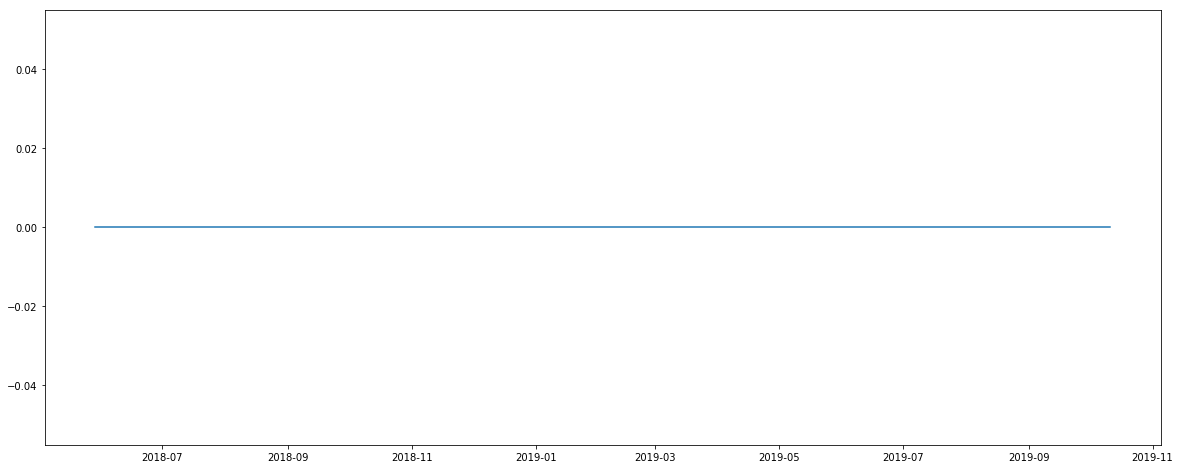

In [17]:
if __name__ == "__main__":
    
    import requests
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from scipy import stats
    import matplotlib.pyplot as plt

    x = Data_Puller('BTC','BCH','day',500)
    x.get_data()
    q = x.fetch_df()
    p = Strategy()
    p.strat()
    p.get_portfolio()
